# Homework 5 - Explore Wikipedia's hyperlinks network

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import seaborn as sns
import collections
import pickle
import random
from tqdm import tqdm
from functions import *
import operator

# Preprocessing

In [2]:
file_page = "wiki-topcats-page-names.txt"
file_category = "wiki-topcats-categories.txt" 
file_graph = "wikigraph_reduced.csv"
path = "C:\\Users\\Alessandra\\Downloads\\"

### Read the categories

In this section we read, process and organize the file relating to the categories. Since an article can belong to several categories, for each article we choose a single category at random among its own.

In [3]:
f = open(file_category, encoding='utf-8')

In [4]:
pages_per_categories = pd.read_csv(file_category,names=['cats'])
pages_per_categories = pd.DataFrame(pages_per_categories.cats.str.split(' ', 1).tolist(), columns = ['cats','pages'])

In [5]:
pages_per_categories["cats"] = pages_per_categories["cats"].str.strip("-")
pages_per_categories['cats'] = pages_per_categories['cats'].str.replace("Category:", "")
pages_per_categories['cats'] = pages_per_categories['cats'].str.replace(";", "")
pages_per_categories['cats'] = pages_per_categories['cats'].str.replace("_", " ")

In [6]:
#check if there null vales in the dataset
pages_per_categories.isnull().sum()

cats       0
pages    538
dtype: int64

In [7]:
#Remove the null values.
pages_per_categories.dropna(inplace = True)

In [8]:
pages_per_categories.isnull().sum()

cats     0
pages    0
dtype: int64

In [9]:
pages_per_categories_dict = dict(pages_per_categories.values.tolist())

In [10]:
separated_pages_per_categories_dict = {}
for key in pages_per_categories_dict:    
    if pages_per_categories_dict[key] != None:    
        pages = pages_per_categories_dict[key].split()     
        separated_pages_per_categories_dict = add_values_in_dict(separated_pages_per_categories_dict, key, pages)

In [11]:
inverted_dict = {}
for k in tqdm(separated_pages_per_categories_dict.keys()):
    for node in separated_pages_per_categories_dict[k]:
        if int(node) not in  inverted_dict.keys():
            inverted_dict[int(node)] = []
            inverted_dict[int(node)].append(k)
        else:
            inverted_dict[int(node)].append(k)

100%|██████████████████████████████████████████████████████████████████████████| 16826/16826 [00:07<00:00, 2214.28it/s]


In [12]:
count = 0
for k in inverted_dict.keys():
    if len(inverted_dict[k]) > 1:
        count += 1
print(count)     

962375


In [13]:
random.seed(54557)
for k in inverted_dict.keys():
    chosen = random.choice(inverted_dict[k])
    inverted_dict[k] = [chosen]

In [14]:
# build the dictonary such that: key=category ----> value=pages
cat_pages_dict = {}
for k in tqdm(inverted_dict.keys()):
    for node in inverted_dict[k]:
        if node not in  cat_pages_dict.keys():
            cat_pages_dict[node] = []
            cat_pages_dict[node].append(k)
        else:
            cat_pages_dict[node].append(k)

100%|████████████████████████████████████████████████████████████████████| 1778370/1778370 [00:02<00:00, 854100.29it/s]


In [15]:
#save inverted index to reuse them later
with open("dict_page_category.pkl", "wb") as out:
    pickle.dump(inverted_dict, out)

In [16]:
#save the dictionary of categories to reuse them later
a_file = open("cat_pages_dict.pkl", "wb")
pickle.dump(cat_pages_dict, a_file)
a_file.close()

In [17]:
#To load saved data
with open("cat_pages_dict.pkl", "rb") as file:
    cat_pages_dict = pickle.load(file)

# [RQ1] Build the graph G=(V, E) and provide basic information.
where V is the set of articles and E the hyperlinks among them.

- The graph directed or undirected
- How many articles are there
- How many hyperlinks between pages exist
- The graph density, is the graph dense or sparse? 
- Visualize the nodes' degree distribution

Build the dataframe and check for invalid values:

In [18]:
graph_ds=pd.read_csv(file_graph, sep = '\t', names = ['id','source', 'dest'], header = 0, index_col = 'id')

In [19]:
graph_ds.isnull().sum()

source    0
dest      0
dtype: int64

In [20]:
graph_ds.head()

,source,dest
id,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


## Is the graph directed?

For answer to this question we check if all the pairs source - destination appears also as destination - source. For istance if the first row of the dataset is:

| Source      | Destination |
| ----------- | ----------- |
| A           | B           |

we test if there are also:

| Source      | Destination |
| ----------- | ----------- |
| B           | A           |

                                                                           (Fitic table not related to our datset)

in the dataset. If this occurs for each rows we say that graph in **unidirected**, otherwise, we say the graph is **directed**.

In [21]:
#input dict: dictonary were for each source node maps the list of destinations
#output dict: dictonary were for each destination node maps the list of sources pointing to it
input_dic = graph_ds.groupby(['source'])['dest'].apply(list).to_dict()
output_dic = graph_ds.groupby(['dest'])['source'].apply(list).to_dict()

In [22]:
is_undirected = []
for node in input_dic.keys():
    outputs = input_dic[node]
    for out in outputs:
        if (output_dic[out] == node):
            is_undirected.append(True)
        else:
            is_undirected.append(False)

In [23]:
if all(is_undirected):
    print("The graph is undirected.")
else:
    print("The graph is directed.")

The graph is directed.


## How many articles are we considering?

The number of articles is the number of nodes:

In [24]:
#numer of nodes
source_set = set(graph_ds['source'])
dest_set = set(graph_ds['dest'])
len(source_set.union(dest_set))

98343

## How many hyperlinks between pages exist?

The number of hyperlinks is the number of edges, that is the number of rows in the dataset, verifing that there are not duplicates pairs _source_ -> _destination_.
So, we first check if the there are duplicates rows, if not the number of hyperlinks is the number of rows.

In [25]:
# DataFrame.any Return True if one (or more) elements are True.
any(graph_ds.duplicated(subset = ['source', 'dest']))

False

There are not duplicated.

Let's see the number of edges:

In [26]:
#number of edges:
len(graph_ds)

483094

Now we build the graph using networkx library and checks the results:

In [27]:
%%time
G = nx.convert_matrix.from_pandas_edgelist(graph_ds, 'source','dest', create_using=nx.DiGraph())

Wall time: 1.21 s


In [28]:
print()
print("Number of nodes:  %d\nNumber of edges: %d\n" % (G.number_of_nodes() , G.number_of_edges()))


Number of nodes:  98343
Number of edges: 483094



## Compute the average number of links in an arbitrary page. 

- Do you believe that the graph is dense or sparse?

In [29]:
random_row = graph_ds.sample()
random_page_number = random_row['source'].values[0]
print(random_page_number)
random_row

1061107


,source,dest
id,,
16080333,1061107,1060377


In [30]:
#(number of out links + number of in links) divided by 2
print(graph_ds[graph_ds.source == random_page_number])
print(graph_ds[graph_ds.dest == random_page_number])
(len(graph_ds[graph_ds.source == random_page_number]) + len(graph_ds[graph_ds.dest == random_page_number])) / 2

           source     dest
id                        
16080313  1061107  1049002
16080314  1061107  1054436
16080318  1061107  1058160
16080321  1061107  1059218
16080322  1061107  1059230
16080323  1061107  1059567
16080329  1061107  1060209
16080330  1061107  1060323
16080332  1061107  1060375
16080333  1061107  1060377
16080335  1061107  1060425
16080336  1061107  1060551
16080341  1061107  1060855
16080353  1061107  1061862
16080354  1061107  1061874
16080357  1061107  1061925
16080363  1061107  1062286
16080367  1061107  1062340
16080368  1061107  1062428
16080369  1061107  1062429
16080370  1061107  1062432
16080371  1061107  1062462
16080373  1061107  1062501
16080374  1061107  1062551
16080375  1061107  1062562
16080383  1061107  1063573
16080384  1061107  1063986
16080386  1061107  1064133
16080387  1061107  1064298
16080391  1061107  1085646
16080393  1061107  1165907
16080397  1061107  1179870
16080402  1061107  1236506
16080404  1061107  1262224
           source     dest
i

35.0

## What is the graph density? 

Given a graph G = (V,E) where E is the number of edges and V is the number of vertices, the graph density of a graphs is defined to be the ratio of the number of edges $|E|$ with respect to the maximum possible edges. For a directed graph the maximum possible edges is 2 times the number of possible pairs, in other words $2 \binom{V}{2} = |V| (|V|-1) $. The density is then $$ \frac{|E|} {|V| (|V|-1)} $$

The maximal density is 1 (for complete graphs) and the minimal density is 0.

In [31]:
nnodes = G.number_of_nodes() 
nedges = G.number_of_edges()
print('(density, number of nodes, number of edges)')
(round(nedges/(nnodes*(nnodes-1)),7), nnodes, nedges)

(density, number of nodes, number of edges)


(5e-05, 98343, 483094)

Since the density is equal to 0,00005 we think the graph is **sparse**.

## The nodes' degree distribution

The degree of a node is the number of connections it has to other nodes. Since the network is directed, the nodes have two different degrees, the in-degree, which is the number of incoming edges, and the out-degree, which is the number of outgoing edges. The degree distribution is the probability distribution of these degrees over the whole network.
In particular, the degree distribution $P(k)$ is the fraction of nodes in the network with degree k,
given a network with n nodes and $n_{k}$ of them have degree k, we have $P(k)={\frac {n_{k}}{n}}$.

In [32]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 98343
Number of edges: 483094
Average in degree:   4.9123
Average out degree:   4.9123


In [33]:
in_degree  =  [deg for (node, deg) in G.in_degree()]
out_degree =  [deg for (node, deg) in G.out_degree()]
tot_degree =  [deg for (node, deg) in G.degree()]

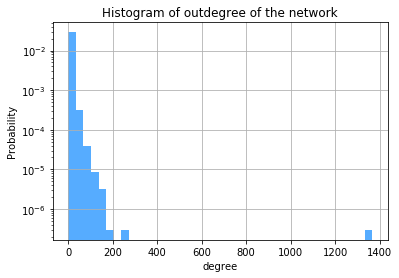

In [34]:
plt.hist(out_degree, 40, density=True, facecolor='dodgerblue', alpha=0.75)
plt.xlabel('degree')
plt.ylabel('Probability')
plt.title('Histogram of outdegree of the network')
plt.yscale('log')
plt.grid(True)
plt.show()

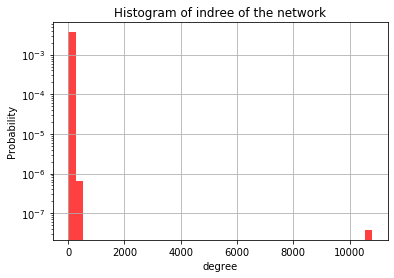

In [35]:
plt.hist(in_degree, 40, density=True, facecolor='r', alpha=0.75)
plt.xlabel('degree')
plt.ylabel('Probability')
plt.title('Histogram of indree of the network')
plt.yscale('log')
plt.grid(True)
plt.show()

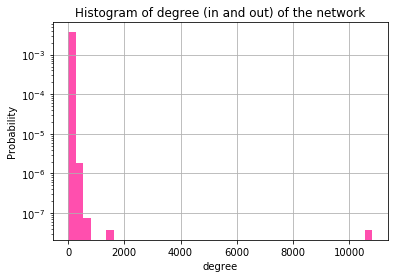

In [36]:
plt.hist(tot_degree, 40, density=True, facecolor='deeppink', alpha=0.75)
plt.xlabel('degree')
plt.ylabel('Probability')
plt.title('Histogram of degree (in and out) of the network')
plt.yscale('log')
plt.grid(True)
plt.show()

In all the three graphs, we see how the majority of nodes have low degree, but there are a small number of high-connected nodes, the latter are called called hubs.

# [RQ2] Nearest pages

We implemented a function that with the breadth first serch algorithm return a set of nodes which distance, from a source node, is below or equal to a chosen integer.

In [37]:
source = 95
N_clicks = 4
print(Nearest_page(G, source, N_clicks, input_dic))

[95, 1185516, 150451, 1062563, 1178930, 1184017, 1184695, 1761109, 397380, 1061132, 1064955, 1065488, 1163156, 1175482, 1179311, 1179588, 1180112, 1181134, 1183515, 1184448, 1184640, 1184726, 1184788, 1185078, 1592499, 1595904, 1055135, 1060251, 1061272, 1061724, 1061730, 1061843, 1061970, 1062002, 1062894, 1067629, 1068471, 1164847, 1179870, 1184170, 1184225, 1225480, 1503428, 1503585, 1596827, 775156, 1520595, 1597034, 1661959, 1175314, 1185314, 1175751, 1181412, 1181020, 208002, 1244721, 820059, 1075210, 1182721, 1761772, 943780, 1183891, 1551064]


# [RQ3] 
We decided to use the previously created dictionaries, one containing the source pages and the other containing the target pages associated with each node of the graph.<br>
Both were useful, one for the in-degree centrality calculation and the other for the BFS.
Finally, we decided to use degree centrality as a measure of centrality for the simplicity of the computation.

In [38]:
pages_list = cat_pages_dict['Living people']
min_clicks(G, 'Living people', pages_list, output_dic, input_dic)

{272780: 1,
 420320: 1,
 1061803: 1,
 1061870: 1,
 1061917: 1,
 1062035: 1,
 601951: 2,
 1055960: 2,
 1268003: 6,
 1492207: 7,
 1495009: 8,
 501323: 11,
 144642: 13,
 1061396: 14,
 1163344: 14,
 1163443: 16,
 1502404: 16,
 1503599: 16,
 723463: 18,
 1062104: 19,
 1061809: 19,
 1061923: 19,
 820612: 20,
 1062041: 22,
 1120972: 23,
 1664231: 24,
 626817: 27,
 1164467: 27,
 1169637: 27,
 1060302: 29,
 1163108: 29,
 1062117: 31,
 1163556: 31,
 1163887: 31,
 1141237: 34,
 1401669: 34,
 1164632: 36,
 633431: 37,
 1060815: 37,
 1163855: 37,
 1223799: 37,
 1061843: 38,
 501303: 39,
 1224890: 39,
 925954: 40,
 1165196: 41,
 639030: 42,
 1557806: 57,
 1062182: 61,
 805060: 62,
 468460: 70,
 1110444: 73,
 1015403: 75,
 1165107: 75,
 1060979: 78,
 1163796: 89,
 826711: 92,
 1061042: 95,
 1247440: 105,
 1163802: 113,
 633792: 114,
 688992: 114,
 1164020: 131,
 725247: 132,
 1503425: 133,
 1503877: 133,
 1061730: 134,
 1225480: 134,
 1061104: 135,
 1504548: 135,
 1520595: 135,
 1211099: 136,
 105975

# [RQ 4]
Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.<br>
Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?<br> 

The smallest number of cuts to be made so that two nodes of the subgraph are disconnected is equal to the number of possible paths that connect the two nodes.<br>
Because of this, we will proceed with calculating the amount of all possible paths between node "u" and node "v".

In [39]:
def min_cuts(G, source, target, path = []):
    
    path = path + [source]
    n_cuts = 0
    
    if source == target:
        return [path]
        
    if source not in G.nodes():
        print("non c'è il nodo source")
        return []
        
    paths = []
    
    for node in G[source]:
            
        if node not in path:
        
            newpaths = [min_cuts(G, node, target, path)]
                
            for newpath in newpaths:
                #paths.append(newpath)
                n_cuts += 1
                
    return n_cuts

Our goal is to extract a subgraph of DG using the nodes contained in 2 categories.
Then we need to choose randomly 2 nodes from the subgraph and then compute the min_cut between them

In [40]:
#here we extract the nodes from 2 random categories
import random

category_1 = random.choice(list(inverted_dict.values()))
#category_1 = ['Buprestoidea']
category_2 = random.choice(list(inverted_dict.values()))

while category_1 == category_2:
    category_2 = random.choice(list(inverted_dict.values()))
    


pages_from_cat_1 = cat_pages_dict[category_1[0]]
pages_from_cat_2 = cat_pages_dict[category_2[0]]

pages_pt1 = []

for page in pages_from_cat_1:
    page = int(page)
    pages_pt1.append(page)
    
pages_pt2 = []

for page in pages_from_cat_2:
    page = int(page)
    pages_pt2.append(page)
    
#since there are no repetitions we can create the final list using a simple union
list_of_nodes = pages_pt1 + pages_pt2

In [41]:
subGr = G.subgraph(list_of_nodes) #here we create the subgraph from the two rnd categories
#subGr.nodes()

In [42]:
#now we just pick two RND nodes from the list_of_nodes and compute the min_cuts between them

if len(subGr.nodes()) != 0:
    nodes = random.sample(subGr.nodes(), 2)
    node_1 = nodes[0]
    node_2 = nodes[1]

    n_cuts = min_cuts(subGr, node_1, node_2)
#print(n_cuts)
    print("The number of cuts needed to separe ", node_1, " and ", node_2, " is equal to ", n_cuts)
else:
    print("No such subgraph created")

The number of cuts needed to separe  136176  and  1110251  is equal to  0


# [RQ5]
In the function "Class_Distance" we evaluate the distance between two class computing the mean of the shortest path for each pair of the nodes in the sub graph consisting of the nodes belonging to two different classes. if there are no edges between nodes belonging to two different classes, we set the distance between infinite.<br>
Shortest path between two nodes is computing with the breadth first search algorithm.

In [43]:
distance_class = Class_Distance(G, 'English television actors', cat_pages_dict)  

100%|██████████████████████████████████████████████████████████████████████████| 16821/16821 [00:08<00:00, 1890.98it/s]


In [44]:
pd.DataFrame.from_dict(distance_class, orient='index', columns=['distance'])\
.sort_values('distance', ascending=True).head(60)

,distance
Directorial debut films,1.000000
1980s thriller films,1.000000
Films set within one day,1.000000
2002 films,1.000000
Fictional mercenaries,1.000000
Independent films,1.000000
Films set in England,1.000000
1980s comedy films,1.000000
1993 films,1.000000
Coming-of-age films,1.000000


# [RQ6] PageRank 
#### Write a function that sorts the categories in the graph according to their PageRank (PR)

### Theory:

Given a web graph, the **PageRank** of a page (a node of the web graph) is a numerical score, between 0 and 1, based on the links structure of the network. 

In order to assign the score to each page, we consider the **Random Surfer Model**: suppose the surfer who starts at a web page and executes a random walk on the Web, in every step he choose two modes: 
with probability  $(1 - \alpha)$  go to a page whose link is present on the current page, or with probability  $\alpha$  jump to any other page (typing a andress into the URL bar of his browser). The latter modality is called **teleporting**.

Given a network on N pages, a given step, the surfer perform a Bernoulli test to decide the modality; if the first modality has been chosen, the surfer chooses a link among those present on the current page uniformly, that is, if the page contains M links, each of them has a probability of $\frac{1}{M}$ to be chosen. If the second mode is selected, the surfer chooses a random page uniformly, so since there are N pages, all the pages have a probability of $\frac{1}{N}$ to be choosen.

We report, for each page $i$, the probability of ending up on another page $j$ in $N x N$ matrix $P$ called **transition matrix**, where the item $P[i][j]$ is the probability of end up in the page $j$ if I am in page $i$, that is $$P[i][j] = (1 - \alpha) \times \frac{1}{M} + \alpha \times \frac{1}{N}$$ where M is the number of outgoing links of the page i. If a page i has no outgoing link we set at $\frac{1}{N}$ the probability of go to any other node.

It is clear that we can build the P matrix using the **Adjacency Matrix $A$**, where the element $A[i][j]$ is $1$ if there is a link between $i$ and $j$, $0$ otherwise. In fact $$ P = (1 - \alpha) \times A' + \alpha \times \frac{1}{N} \times J $$
where $J$ is the matrix of all ones, $A'$ is the matrix $A$ where each row is divided by the sum of the ones in the row (that is the number of outgoing links) and if a row in $A$ has no $1$ (a page i has no outgoing link), we set all the elements of the row to $\frac{1}{N}$.  

Now we consider the $1 \times N$ vector $q^t$, that contains the probability of being in each nodes at the time t, in other words the the surfer’s distribution at time t. 
Cosindering $q^0$ as the starting state, by definition, 

at time t = 1 the distribution is $q^1 = q^0 \times P$. 

At time t = 2 is $q^2 = q^1 \times P = q^0 \times P^2$,

a t = 3 is $q^3 = q^0 \times P^3$, and so on.

We are interesting at the distribution for large t. It is shown that the distribution for large t converges to a certain value. We call the $1 \times N$ vector $\pi$ the stationary distribuition. $\pi$ tells us, for each page, the percentual of times the surfer stays in each state, we define the **PageRank** of the page $i$ the i-th entries of $\pi$. If $\pi$ is the stationary distribution of the surfer, in the next step the distribution remains the same $\pi$, so the following condition holds $\pi \times P = \pi$. So given $\pi$ the stationary distribution, we have that $\pi \times P = 1 \pi$, so 1 is an eigenvalue of P.

In other words, the **PageRank** of the page $i$ is given by $\pi[i]$, where $\pi$ is the eigvector associates to the eigvalue 1 of the matrix P.

### Practical steps:

In our analysis the nodes are the categories of the pages.

We use two dataset:

- Dataset of the web graph. In which every row indicates an edge and the columns are the source and the destination, respectively.

- Dataset of the categories, reports the category to which each page belongs.

1) We associate the respective category (dataset of categories) to each node (dataset of web). To do this, we do an inner join between the 2 datasets twice, to associate category to the source page and to associate the category to the destination nodes.

2) Build the Adjacency Matrix between categories source and destination.

3) Build the Transition Matrix from the Adjacency Matrix.

4) Compute the PageRank as eigvector associates to the eigvalue 1 of Transition Matrix.


In [45]:
#input
with open("dict_page_category.pkl", "rb") as file:
    inverted_dict = pickle.load(file)

In [46]:
#build a dataframe page category from the dictonary 
pages_list =list(inverted_dict.keys()) #retrieve list of pages 
category_list = [item for list_of_list in list(inverted_dict.values()) for item in list_of_list] #retrieve list of categories
category_df = pd.DataFrame({'page' : pages_list, 'category':category_list})

In [47]:
graph_ds.head()

,source,dest
id,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


In [48]:
category_df.head()

,page,category
0,301,Buprestoidea
1,302,Buprestoidea
2,303,Insect families
3,304,Buprestoidea
4,305,Buprestoidea


In [49]:
#associates each nodes with its own category
graph_ds = graph_ds.merge(category_df.rename(columns={"page": "source"}), how = "inner", on = "source").\
rename(columns={"category": "category_source"})
graph_ds = graph_ds.merge(category_df.rename(columns={"page": "dest"}), how = "inner", on = "dest").\
rename(columns={"category": "category_dest"})
graph_ds.head(10)

,source,dest,category_source,category_dest
0,95,1185516,Debut albums,Living people
1,1198096,1185516,Debut albums,Living people
2,1230864,1185516,Debut albums,Living people
3,108,1059989,Debut albums,20th Century Fox films
4,137144,1059989,Bisexual actors,20th Century Fox films
5,374066,1059989,American films,20th Century Fox films
6,635998,1059989,Living people,20th Century Fox films
7,688704,1059989,American female adult models,20th Century Fox films
8,688741,1059989,Living people,20th Century Fox films
9,689109,1059989,American film actors,20th Century Fox films


In [50]:
g = graph_ds.groupby(["category_source", "category_dest"]).agg(number_of_links = ('source', 'count'))
g

number_of_links
category_source              category_dest                                                      
1. FC Kaiserslautern players Expatriate footballers in Belarus                                 1
                             Spain youth international footballers                             1
1. FC Kln players            AS Saint-tienne players                                           1
                             Belgian Pro League players                                        1
                             German football managers                                          1
...                                                                                          ...
guilas Cibaeas players       Cleveland Indians players                                         1
                             Kansas City Royals players                                        1
                             Major League Baseball pitchers                                    2
                             New York Yankees players                                          1
                             Outstanding Performance by a Cast in a Motion P...                1

[156248 rows x 1 columns]

For istance, looking at the first category "_1. FC Kaiserslautern players_" we see that it has two links: one to the category "_Expatriate footballers in Belarus_", and the other to "_Spain youth international footballers_".
In our graph there are, hence, 2 links out of the first category, directed where the second and the category said.

In [51]:
category_graph = graph_ds[["category_source","category_dest"]]

In [52]:
category_graph.head()

,category_source,category_dest
0,Debut albums,Living people
1,Debut albums,Living people
2,Debut albums,Living people
3,Debut albums,20th Century Fox films
4,Bisexual actors,20th Century Fox films


Sice the total number of categories are $5001$,  the **adjacency matrix** will be a $5001 \times 5001$ square matrix.  In order to get it, we first add the missing categories to the columns _category_source_ and _category_dest_.

In [53]:
categories = set(graph_ds['category_source']).union(set(graph_ds['category_dest']))

In [54]:
print('Number of categories:', len(categories))

Number of categories: 5001


In [55]:
missing_source_category = categories - set(graph_ds['category_source'])
missing_dest_category = categories - set(graph_ds['category_dest'])
print('Number of categories missing in the source set:      %d\nNumber of categories missing in the destination set: %d' %
      (len(missing_source_category), len(missing_dest_category)))

Number of categories missing in the source set:      277
Number of categories missing in the destination set: 410


In [56]:
#add missing categories (source and destination) to the dataframe
category_ds = pd.concat(
    [category_graph, 
     pd.DataFrame({'category_source':list(missing_source_category), 'category_dest':[''] * len(missing_source_category)})], 
    ignore_index = True)
category_ds = pd.concat(
    [category_ds, 
     pd.DataFrame({'category_source':[''] * len(missing_dest_category), 'category_dest':list(missing_dest_category)})], 
    ignore_index = True)

In [57]:
category_ds

,category_source,category_dest
0,Debut albums,Living people
1,Debut albums,Living people
2,Debut albums,Living people
3,Debut albums,20th Century Fox films
4,Bisexual actors,20th Century Fox films
...,...,...
483776,,Expatriate footballers in Thailand
483777,,People from Brno
483778,,Essendon Football Club players
483779,,FIFA World Cup referees


In [58]:
cross = pd.crosstab(category_ds['category_source'], category_ds['category_dest']).drop(columns=['']).drop([''])

In [59]:
cross

category_dest,1. FC Kaiserslautern players,1. FC Kln players,1. FC Nuremberg players,1. FC Union Berlin players,1. FSV Mainz 05 players,12th-century English people,13th-century Christian saints,13th-century English people,13th-century Roman Catholic bishops,14th-century English people,...,Younger sons of baronets,Younger sons of barons,Younger sons of dukes,Younger sons of earls,Yugoslav films,Yugoslav footballers,Yugoslavia international footballers,ZX Spectrum games,Zombie films,guilas Cibaeas players
category_source,,,,,,,,,,,,,,,,,,,,,
1. FC Kaiserslautern players,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1. FC Kln players,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1. FC Nuremberg players,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1. FC Union Berlin players,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1. FSV Mainz 05 players,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yugoslav footballers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
Yugoslavia international footballers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZX Spectrum games,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
nodes = cross.columns

In [61]:
adj_matrix = cross.to_numpy()
number_of_cg = adj_matrix.shape[1] #number_of_cg is the number of categories

In [62]:
print('Number of rows and columns in the Adjacency matrix')
adj_matrix.shape

Number of rows and columns in the Adjacency matrix


(5001, 5001)

In [63]:
print('Number of egdes in the Adjacency matrix:')
sum(sum(adj_matrix))

Number of egdes in the Adjacency matrix:


483094

#### Build the Tansition Matrix

Now we will retrieve the **Tansition Matrix** starting from the **Adjacency Matrix** follow the formula written above, and considering the probability of teleporting $\alpha = 0.1$.

Then we compute the **PageRank** as the entries of the principal left eigenvector of the matrix P — the one with eigenvalue 1. The i-th entries of the eigenvector is the PageRank of the category in the i-th column of the P matrix, so getting the getting the indices of the maximum values in the eigvector we will sort the categories according to PageRank from highest to lowest.

In [64]:
alpha = 0.1

In [65]:
#if a row contains only 0, we replace it with a row of all ones.
adj_matrix[np.all(adj_matrix == 0, axis=1)] = np.repeat(1, adj_matrix.shape[1])

In [66]:
#divided each row by the sum of element of the row
#reference: https://stackoverflow.com/questions/8904694/how-to-normalize-a-2-dimensional-numpy-array-in-python-less-verbose
row_sum = adj_matrix.sum(axis=1)
adj_matrix = adj_matrix / row_sum[:, np.newaxis]

In [67]:
#check if the sum per rows are all equal to one
#since we are dealing with float numbers we are gonna use np.isclose()
row_sum = adj_matrix.sum(axis=1)
all(np.isclose(row_sum,1))

True

In [68]:
P = (alpha/number_of_cg) * np.repeat(1, number_of_cg*number_of_cg).reshape(number_of_cg, number_of_cg) + (1 - alpha) * adj_matrix

In [69]:
P

array([[1.99960008e-05, 1.99960008e-05, 1.99960008e-05, ...,
        1.99960008e-05, 1.99960008e-05, 1.99960008e-05],
       [1.99960008e-05, 1.99960008e-05, 1.99960008e-05, ...,
        1.99960008e-05, 1.99960008e-05, 1.99960008e-05],
       [1.99960008e-05, 1.99960008e-05, 1.99960008e-05, ...,
        1.99960008e-05, 1.99960008e-05, 1.99960008e-05],
       ...,
       [1.99960008e-05, 1.99960008e-05, 1.99960008e-05, ...,
        1.99960008e-05, 1.99960008e-05, 1.99960008e-05],
       [1.99960008e-05, 1.99960008e-05, 1.99960008e-05, ...,
        1.99960008e-05, 1.99960008e-05, 1.99960008e-05],
       [1.99960008e-05, 1.99960008e-05, 1.99960008e-05, ...,
        1.99960008e-05, 1.99960008e-05, 1.99960008e-05]])

In [70]:
P.shape

(5001, 5001)

In [71]:
#eigvalues of P 
linalg.eigvals(P)

array([ 1.00000000e+00+0.00000000e+00j,  8.92891557e-01+0.00000000e+00j,
        8.99880540e-01+0.00000000e+00j, ...,
        2.98738545e-17+0.00000000e+00j, -1.89249385e-18+1.63969082e-17j,
       -1.89249385e-18-1.63969082e-17j])

In [72]:
#left eigvector of transition matrix P, corrisponding to the eingvalue 1
v = linalg.eig(P, left=True, right=False)[1][:,0]
v = np.abs(v)

In [73]:
v

array([0.00060792, 0.00036388, 0.00083971, ..., 0.00058727, 0.00128782,
       0.00068307])

In [74]:
ideces_pr = np.argsort(-v)
print('indices of the maximum values:')
print(ideces_pr)

indices of the maximum values:
[3049  718 2144 ... 2493 4339 1525]


###### Top 100 categories based on PageRank 

For clarity of representation, we show the first 100 categories:

In [75]:
i = 1
for c in nodes[ideces_pr[:100]]:
    print('%d) %s'%(i, c))
    i += 1

1) Living people
2) American film actors
3) English-language films
4) American television actors
5) American films
6) English footballers
7) Black-and-white films
8) Members of the United Kingdom Parliament for English constituencies
9) American silent film actors
10) American stage actors
11) Main Belt asteroids
12) The Football League players
13) Harvard University alumni
14) Major League Baseball pitchers
15) Year of death missing
16) American voice actors
17) Conservative Party (UK) MPs
18) Year of birth missing
19) Premier League players
20) Actors from New York City
21) Actors from California
22) Deaths from myocardial infarction
23) Members of the Privy Council of the United Kingdom
24) English football managers
25) American people of Irish descent
26) Association football forwards
27) Association football midfielders
28) American film producers
29) Rivers of Romania
30) American comedy films
31) England international footballers
32) American film directors
33) 20th-century acto